In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 4.1 MB/s 


In [ ]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split

import shap

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/newdata5.csv', encoding='cp949')
data

,날짜,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,2012-05-01 0:00,0.0,0.0,0.0,0.0,575.70,193.0,469.05,729.80,540.18,310.7,300.2,290.0,275.3
1,2012-05-01 0:10,0.0,0.0,0.0,0.0,575.30,199.0,498.00,731.48,540.18,314.7,300.2,290.0,275.3
2,2012-05-01 0:20,0.0,0.0,0.0,0.0,555.00,207.0,490.68,726.42,540.18,313.7,301.2,290.0,275.3
3,2012-05-01 0:30,0.0,0.0,0.0,0.0,575.70,215.0,476.21,726.42,552.17,311.7,301.2,290.0,276.3
4,2012-05-01 0:40,0.0,0.0,0.0,0.0,575.40,226.0,476.21,707.17,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,0.0,0.0,0.0,0.0,258.67,407.0,319.84,-456.41,974.40,288.0,295.0,299.0,306.0
276332,2022-07-18 23:20,0.0,0.0,0.0,0.0,258.58,431.0,314.01,-717.30,1006.88,287.0,303.0,304.0,308.0
276333,2022-07-18 23:30,0.0,0.0,0.0,0.0,258.56,453.0,387.55,-843.37,1039.90,299.0,307.0,309.0,310.0
276334,2022-07-18 23:40,0.0,0.0,0.0,0.0,258.65,476.0,454.91,-1023.37,1073.46,309.0,311.0,314.0,312.0


In [ ]:
광진교 = pd.read_csv('/content/drive/MyDrive/신입기수 프로젝트/Dataset/cnn_광진.csv')
data['광진교_수위'] = 광진교['수위']

data.set_index(keys = ['날짜'], inplace = True)
data.index = pd.to_datetime(data.index, format = '%Y-%m-%d %H:%M')

input_y = data['한강대교_유량']
input_x = data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
data = input_regular

In [ ]:
data

,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,광진교_수위,한강대교_유량
날짜,,,,,,,,,,,,,,,
2012-05-01 00:00:00,0.0,0.0,0.0,0.0,0.058462,0.191781,0.024640,0.147596,0.011070,0.049611,0.060000,0.051621,0.056478,0.056452,729.80
2012-05-01 00:10:00,0.0,0.0,0.0,0.0,0.058447,0.199253,0.027800,0.147654,0.011070,0.053502,0.060000,0.051621,0.056478,0.056452,731.48
2012-05-01 00:20:00,0.0,0.0,0.0,0.0,0.057689,0.209215,0.027001,0.147478,0.011070,0.052529,0.061111,0.051621,0.056478,0.056452,726.42
2012-05-01 00:30:00,0.0,0.0,0.0,0.0,0.058462,0.219178,0.025421,0.147478,0.011475,0.050584,0.061111,0.051621,0.058140,0.056452,726.42
2012-05-01 00:40:00,0.0,0.0,0.0,0.0,0.058451,0.232877,0.025421,0.146810,0.011883,0.050584,0.061111,0.052821,0.059801,0.056452,707.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.0,0.0,0.0,0.0,0.046624,0.458281,0.008355,0.106425,0.025719,0.027529,0.054222,0.062425,0.107475,0.045699,-456.41
2022-07-18 23:20:00,0.0,0.0,0.0,0.0,0.046621,0.488169,0.007719,0.097370,0.026815,0.026556,0.063111,0.068427,0.110797,0.045699,-717.30
2022-07-18 23:30:00,0.0,0.0,0.0,0.0,0.046620,0.515567,0.015745,0.092994,0.027929,0.038230,0.067556,0.074430,0.114120,0.045699,-843.37


In [ ]:
from itertools import combinations

feature_combs = []

for i in range(len(data.columns), 1, -1):
    feature_combs += list(combinations([*range(1, len(data.columns)+1)], i))

In [ ]:
len(feature_combs)

32752

# 청담대교

## ExtraTrees로 변경

In [ ]:
result = pd.DataFrame(columns=['Feature 조합', 'ExtraTrees_RMSE'])

for feature_comb in feature_combs:

    feature_comb = list(feature_comb)
    num_features = len(feature_comb)   # 독립변수 개수

    train_set = data.iloc[0:269423, feature_comb].values
    train_label = data.iloc[1:269424, 10].values   # 청담대교
    test_set = data.iloc[-6913:-1, feature_comb].values
    test_label = pd.read_csv('y_test.csv', encoding='cp949')['청담대교_수위']*100

    train_set, train_label = np.array(train_set).reshape(-1, num_features), np.array(train_label).reshape(-1, 1)
    test_set, test_label = np.array(test_set).reshape(-1, num_features), np.array(test_label).reshape(-1, 1)

    ### ExtraTreesRegressor ###
    et = ExtraTreesRegressor(n_jobs=-1, n_estimators=200)
    et.fit(train_set, np.ravel(train_label))
    y_pred_et = et.predict(test_set)
    et_rmse = mean_squared_error(test_label, y_pred_et, squared=False)
    result.loc[len(result)] = [feature_comb, et_rmse]
    
    print(f'Feature 조합 : {feature_comb} | RMSE : {et_rmse}')
    
    if et_rmse <= 1.5:
        break

IndexError: ignored

##  LGBMRegressor로 변경

In [ ]:
!pip install lightgbm

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
result = pd.DataFrame(columns=['Feature 조합', 'LGBM_RMSE'])

for feature_comb in feature_combs:

    feature_comb = list(feature_comb)
    num_features = len(feature_comb)   # 독립변수 개수

    train_set = data.iloc[0:269423, feature_comb].values 
    train_label = data.iloc[1:269424, 10].values   # 청담대교
    test_set = data.iloc[-6913:-1, feature_comb].values 
    test_label = pd.read_csv('y_test.csv', encoding='cp949')['청담대교_수위']*100

    train_set, train_label = np.array(train_set).reshape(-1, num_features), np.array(train_label).reshape(-1, 1)
    test_set, test_label = np.array(test_set).reshape(-1, num_features), np.array(test_label).reshape(-1, 1)

    ### LGBMRegressor ###
    lgbm = LGBMRegressor(n_jobs=-1, learning_rate=0.1, n_estimators=800)
    lgbm.fit(train_set, np.ravel(train_label))
    y_pred_lgbm = lgbm.predict(test_set)
    lgbm_rmse = mean_squared_error(test_label, y_pred_lgbm, squared=False)
    
    result.loc[len(result)] = [feature_comb, lgbm_rmse]
    print(f'Feature 조합 : {feature_comb} | RMSE : {lgbm_rmse}')
    
    if lgbm_rmse <= 1.5:
        break

## XGBoost로 변경

In [ ]:
import xgboost
from xgboost import XGBRegressor

In [ ]:
data

,대곡교_강수량,진관교_강수량,송정동_강수량,서울시_강수량,방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,광진교_수위,한강대교_유량
날짜,,,,,,,,,,,,,,,
2012-05-01 00:00:00,0.0,0.0,0.0,0.0,0.058462,0.191781,0.024640,0.147596,0.011070,0.049611,0.060000,0.051621,0.056478,0.056452,729.80
2012-05-01 00:10:00,0.0,0.0,0.0,0.0,0.058447,0.199253,0.027800,0.147654,0.011070,0.053502,0.060000,0.051621,0.056478,0.056452,731.48
2012-05-01 00:20:00,0.0,0.0,0.0,0.0,0.057689,0.209215,0.027001,0.147478,0.011070,0.052529,0.061111,0.051621,0.056478,0.056452,726.42
2012-05-01 00:30:00,0.0,0.0,0.0,0.0,0.058462,0.219178,0.025421,0.147478,0.011475,0.050584,0.061111,0.051621,0.058140,0.056452,726.42
2012-05-01 00:40:00,0.0,0.0,0.0,0.0,0.058451,0.232877,0.025421,0.146810,0.011883,0.050584,0.061111,0.052821,0.059801,0.056452,707.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-18 23:10:00,0.0,0.0,0.0,0.0,0.046624,0.458281,0.008355,0.106425,0.025719,0.027529,0.054222,0.062425,0.107475,0.045699,-456.41
2022-07-18 23:20:00,0.0,0.0,0.0,0.0,0.046621,0.488169,0.007719,0.097370,0.026815,0.026556,0.063111,0.068427,0.110797,0.045699,-717.30
2022-07-18 23:30:00,0.0,0.0,0.0,0.0,0.046620,0.515567,0.015745,0.092994,0.027929,0.038230,0.067556,0.074430,0.114120,0.045699,-843.37


In [ ]:
feature_comb = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
data['청담대교_유량'].iloc[-6911:]

날짜
2022-06-01 00:10:00    0.004031
2022-06-01 00:20:00    0.005848
2022-06-01 00:30:00    0.006466
2022-06-01 00:40:00    0.005848
2022-06-01 00:50:00    0.005848
                         ...   
2022-07-18 23:10:00    0.008355
2022-07-18 23:20:00    0.007719
2022-07-18 23:30:00    0.015745
2022-07-18 23:40:00    0.023097
2022-07-18 23:50:00    0.036991
Name: 청담대교_유량, Length: 6911, dtype: float64

In [ ]:
feature_comb = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

num_features = len(feature_comb)   # 독립변수 개수

train_set = data.iloc[0:-6912, feature_comb].values
train_label = data['청담대교_유량'].iloc[1:-6913].values  
test_set = data.iloc[-6912:-1, feature_comb].values
test_label = data['청담대교_유량'].iloc[-6911:].values

train_set, train_label = np.array(train_set).reshape(-1, num_features), np.array(train_label).reshape(-1, 1)
test_set, test_label = np.array(test_set).reshape(-1, num_features), np.array(test_label).reshape(-1, 1)

In [ ]:
model = XGBRegressor(n_jobs=-1, n_estimators=800, learning_rate=0.08, grow_policy='lossguide', num_parallel_tree=4)

In [ ]:
model.fit(test_set, np.ravel(test_label))

[10:08:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(grow_policy='lossguide', learning_rate=0.08, n_estimators=800,
             n_jobs=-1, num_parallel_tree=4)

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test_set)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], test_set[0, :])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:1000], test_set[:1000]
                , feature_names = ['대곡교_강수량',	'진관교_강수량',	'송정동_강수량',	'서울시_강수량',	'방류량',	'강화대교_조위',	'청담대교_유량',	'한강대교_유량',	'행주대교_유량',	'청담대교_수위',	'잠수교_수위',	'한강대교_수위',	'행주대교_수위',	'광진교_수위'])

In [ ]:
import matplotlib 
matplotlib.font_manager._rebuild()

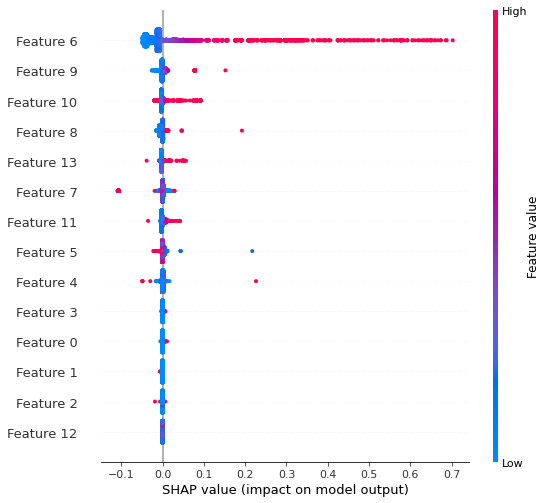

In [ ]:
shap.summary_plot(shap_values, test_set, plot_type='dot')
                  #feature_names = ['대곡교_강수량',	'진관교_강수량',	'송정동_강수량',	'서울시_강수량',	'방류량',	'강화대교_조위',	'청담대교_유량',	'한강대교_유량',	'행주대교_유량',	'ㅠㅠ',	'잠수교_수위',	'한강대교_수위',	'행주대교_수위',	'광진교_수위'])

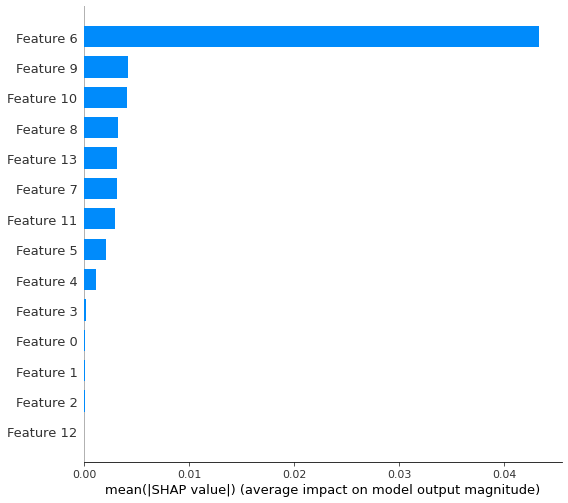

In [ ]:
shap.summary_plot(shap_values, test_set, plot_type='bar')
# feature_names = ['대곡교_강수량',	'진관교_강수량',	'송정동_강수량',	'서울시_강수량',	'방류량',	'강화대교_조위',	'청담대교_유량',	'한강대교_유량',	'행주대교_유량',	'청담대교_수위',	'잠수교_수위',	'한강대교_수위',	'행주대교_수위',	'광진교_수위'])

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


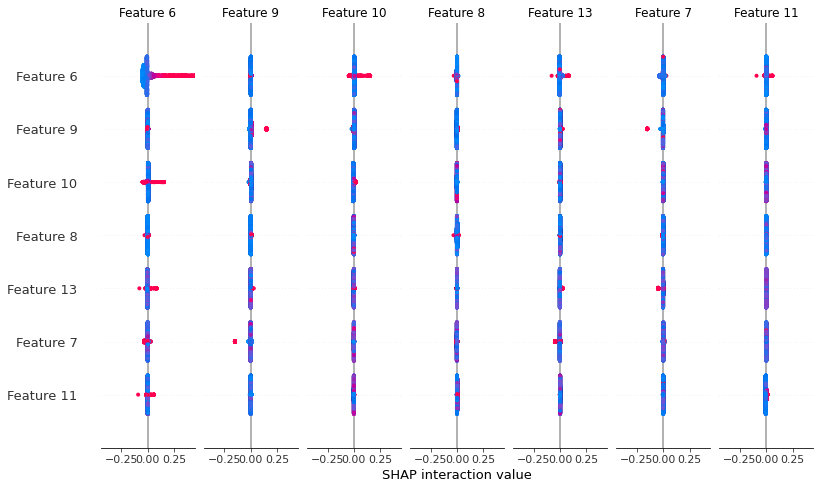

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(test_set)
shap.summary_plot(shap_interaction_values, test_set)

In [ ]:
shap.dependence_plot(
    (Feature 1, Feature 2)),
    shap_interaction_values, test_set,
    display_features=test_set
)

SyntaxError: ignored

In [ ]:
feature_comb = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14]

num_features = len(feature_comb)   # 독립변수 개수

train_set = data.iloc[0:269423, feature_comb].values
train_label = data.iloc[1:269424, 10].values   # 청담대교
test_set = data.iloc[-6913:-1, feature_comb].values
test_label = pd.read_csv('y_test.csv', encoding='cp949')['청담대교_수위']*100

train_set, train_label = np.array(train_set).reshape(-1, num_features), np.array(train_label).reshape(-1, 1)
test_set, test_label = np.array(test_set).reshape(-1, num_features), np.array(test_label).reshape(-1, 1)

### XGBRegressor ###
xgb = XGBRegressor(n_jobs=-1, n_estimators=800, learning_rate=0.08, grow_policy='lossguide', num_parallel_tree=4)
xgb.fit(train_set, np.ravel(train_label))



y_pred_xgb = xgb.predict(test_set)
xgb_rmse = mean_squared_error(test_label, y_pred_xgb, squared=False)
xgb_loss = xgb_rmse / xgb.score(test_set, test_label)
    
print(f'Feature 조합 : {feature_comb} | RMSE : {xgb_rmse} | Loss : {xgb_loss}')

## XGBoost + 다른 데이터

In [ ]:
feature_comb = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14]

num_features = len(feature_comb)   # 독립변수 개수

train_set = data.iloc[0:269423, feature_comb].values
train_label = data.iloc[1:269424, 10].values   # 청담대교
test_set = data.iloc[-6912:, feature_comb].values
test_label = pd.read_csv('y_test.csv', encoding='cp949')['청담대교_수위']*100

train_set, train_label = np.array(train_set).reshape(-1, num_features), np.array(train_label).reshape(-1, 1)
test_set, test_label = np.array(test_set).reshape(-1, num_features), np.array(test_label).reshape(-1, 1)

### XGBRegressor ###
xgb = XGBRegressor(n_jobs=-1, n_estimators=800, learning_rate=0.1, grow_policy='lossguide')
xgb.fit(train_set, np.ravel(train_label))
y_pred_xgb = xgb.predict(test_set)
xgb_rmse = mean_squared_error(test_label, y_pred_xgb, squared=False)
    
print(f'Feature 조합 : {feature_comb} | RMSE : {xgb_rmse}')